In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import ERFutils

# Select experiments and evaluate pattern scaling 
This notebook evaluates the performance of a given pattern against the CMIP6 ensemble mean in terms of RMSE, MAE, bias, and relative bias. Individual plots can be turned off and/or modified within ERFutils.scale_pattern(). Bias should be zero by construction.

Loading 1pctCO2 experiment as training data...
	Loading 1pctCO2 experiment for pattern scaling...

Results are shown in the following order:
['1pctCO2']

Mid-Century Stats:
RMSE: [0.2684]
MAE: [0.1774]
Bias: [0.0]
Relative Bias: [2.0875]

End-of-Century Stats:
RMSE: [0.2879]
MAE: [0.1766]
Bias: [0.0]
Relative Bias: [0.4493]


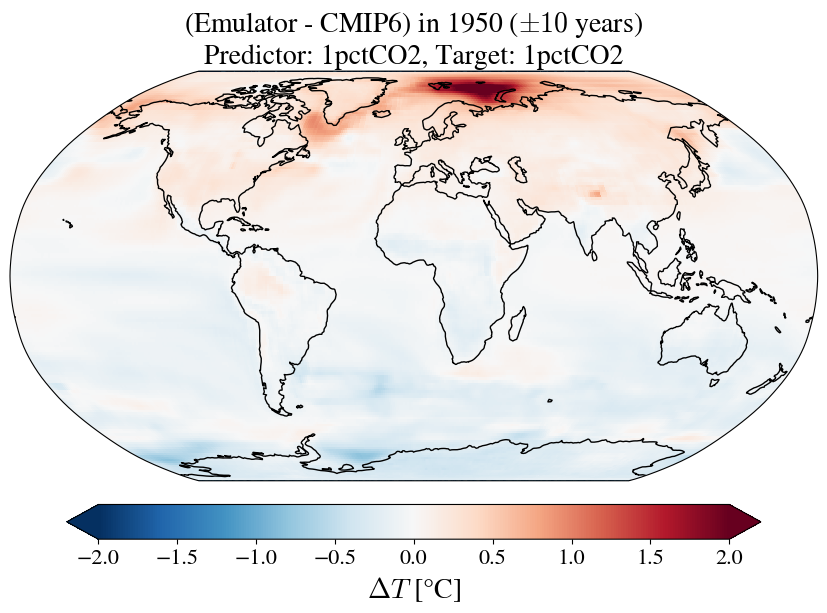

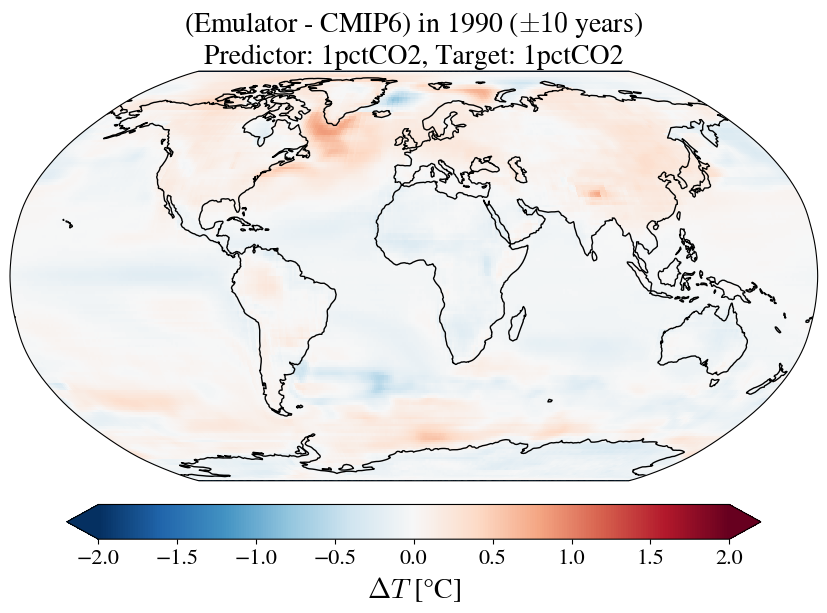

In [3]:
# Specify if we want to plot and/or save results
plot = True
save_result = False
save_fig = False

# Select experiment used for training
train_id = '1pctCO2'
print(f'Loading {train_id} experiment as training data...')

# Select experiments to convolve with for evaluation
scale_all = ['1pctCO2']#,'ssp126','ssp245','ssp370','ssp585']

# Evaluate experiments and record error statistics
(RMSE_short, RMSE_long, MAE_short, MAE_long,
 bias_short, bias_long, rel_bias_short, rel_bias_long) = ERFutils.scale_pattern(train_id, scale_all, plot, save_result, save_fig)